In [1]:
# Copyright 2020 Bimghi Choi. All Rights Reserved.
# 예측 + 투자전략 시스템

# _*_ coding: utf-8 _*_

from tensorflow import keras
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # sataset를 2개로 분리해서 모델1, 2에 할당
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]='0, 1'

In [2]:
import util
import preprocess as prepro
import models
import learn
from learn import GenerateResult
import math
from datetime import datetime

# train, test loss를 graph

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [4]:
#tf.keras.backend.set_floatx('float64')

# GPU 메모리 2GB로 제한

In [5]:
import gc
gc.collect()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
#    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')    
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')    
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
    tf.config.experimental.set_virtual_device_configuration(
        gpus[1],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])    
  except RuntimeError as e:
    # 프로그램 시작시에 가장 장치가 설정되어야만 합니다
    print(e)

In [6]:
file_name = '~/Data/kospi200f_809_0515.csv'
item_name = 'kospi200f_809_0515'
train_start = '2000-01-31'
train_end = '2017-01-02'
test_start = '2017-01-02'
test_end = '2018-12-31'

remove_columns = ['date', '종가']
target_column = '종가'
input_columns = []
target_type = 'rate'

model_name = 'loss_cut-3'
channel = False

trans_day = 20

target_alpha = 100
future_day = 120
train_end_back = -1
n_timestep = 30
time_interval = 20
input_size = 809
n_unit = 500
batch_size = 20
learning_rate = 0.0005
epochs = 500

alpha = 0.05
beta = 0.01

comment = "미래데이터 사용 error수정,예측 모델 MSE loss에 sharp ratior, maximumdrawdown loss 추가"

from datetime import datetime
now = datetime.now().strftime('%Y-%m-%d-%H:%M:%S')
checkpoint_path = model_name + "/pred"+str(future_day)+":"+now+".ckpt"

In [7]:

dataframe = util.read_datafile(file_name)
df = dataframe.copy()
#df = prepro.target_conversion(df, target_column, future_day, type=target_type)
a = []
b = []
for i in range(len(df[target_column]) -future_day):
    df.loc[i, target_column] = ((df.loc[i + future_day, target_column] - df.loc[i, target_column]) 
                                / df.loc[i, target_column]) * target_alpha                                
    df.loc[i, '시가'] = df.loc[i + future_day + train_end_back + 1, '시가']
    a.append(max(df.loc[i  + future_day + train_end_back + 1:i + future_day + 1, '고가']))
    b.append(min(df.loc[i  + future_day + train_end_back + 1:i + future_day + 1, '저가']))
for i in range(len(df['종가']) - future_day):
    df.loc[i, '고가'] = a[i]
    df.loc[i, '저가'] = b[i]

In [8]:
df.head(20)

,date,시가지수(포인트),고가지수(포인트),저가지수(포인트),종가지수(포인트),수익률(%),수익률 (1주)(%),수익률 (1개월)(%),수익률 (3개월)(%),수익률 (6개월)(%),...,"주요상품선물_천연가스(선물, NYMEX)($/mmBtu)",주요상품선물_금(선물)($/ounce),주요상품선물_은(선물)($/ounce),주요상품선물_알루미늄(선물)($/ton),주요상품선물_옥수수(최근월물)(￠/bu),대두박(￠/bu),종가,시가,고가,저가
0,2000-01-31,-0.218225,-0.493106,-0.400439,-0.223565,0.212872,1.352924,-0.851790,-0.382658,-0.162615,...,1.653438,-0.853010,0.974513,0.827681,0.373581,0.614542,-24.038462,92.85,93.25,88.65
1,2000-02-01,-0.213200,-0.230417,-0.373954,-0.595373,-0.407635,1.808646,-1.074203,-1.707405,-0.490731,...,1.687061,-0.039689,0.193571,1.002058,0.594935,0.706918,-19.852622,89.85,95.35,88.65
2,2000-02-02,-0.208520,-0.448886,-0.367787,-0.200398,0.696677,2.107257,-0.769928,-1.558400,0.074389,...,1.809524,0.800355,0.031266,0.069626,0.430159,0.725768,-19.501900,91.85,95.95,91.40
3,2000-02-03,-0.204125,-0.216603,-0.062403,-0.021445,0.366314,1.488978,-0.625155,-1.268930,-0.079967,...,1.213642,1.515992,0.623370,0.378121,0.084769,0.352875,-20.377358,94.35,96.20,92.95
4,2000-02-07,-0.200000,0.378008,0.426748,0.592789,0.949260,1.101574,1.281908,-1.288431,1.273730,...,0.689954,3.856851,0.568635,-0.322023,0.518339,0.702038,-24.029424,95.90,96.20,90.95
5,2000-02-08,-0.196110,0.353748,0.677387,0.254527,-0.366454,1.138729,0.998930,-1.329397,0.942469,...,0.332052,2.657684,1.222974,-0.720402,0.474125,0.440887,-24.164948,93.35,93.55,87.60
6,2000-02-09,-0.192447,0.306497,0.819824,0.658684,0.641075,1.076862,1.233568,-1.637689,0.994675,...,0.557674,3.026664,2.114708,-0.407511,0.622228,0.721716,-28.583029,89.75,90.15,86.20
7,2000-02-10,0.330923,0.617187,0.552762,0.366383,-0.311193,0.651653,0.275024,-1.607973,0.269679,...,0.812787,3.316674,1.871659,-0.157431,0.985272,1.379493,-29.222629,88.75,93.15,86.20
8,2000-02-11,0.977388,0.576306,0.048738,-0.013448,-0.428351,0.326747,0.131530,-1.828185,0.546650,...,0.675096,2.384344,0.988933,-0.154629,0.473525,0.907189,-22.920976,89.35,94.15,88.25
9,2000-02-14,-0.649462,-0.806483,-0.954529,-1.222378,-1.533955,-1.217328,-0.075927,-2.486079,0.140712,...,0.504701,1.935983,0.085505,-0.246361,0.529501,0.923675,-20.043103,91.95,95.35,90.20


In [9]:
column_list = df.columns
column_list

Index(['date', '시가지수(포인트)', '고가지수(포인트)', '저가지수(포인트)', '종가지수(포인트)', '수익률(%)',
       '수익률 (1주)(%)', '수익률 (1개월)(%)', '수익률 (3개월)(%)', '수익률 (6개월)(%)',
       ...
       '주요상품선물_천연가스(선물, NYMEX)($/mmBtu)', '주요상품선물_금(선물)($/ounce)',
       '주요상품선물_은(선물)($/ounce)', '주요상품선물_알루미늄(선물)($/ton)',
       '주요상품선물_옥수수(최근월물)(￠/bu)', '대두박(￠/bu)', '종가', '시가', '고가', '저가'],
      dtype='object', length=814)

In [10]:
#import pandas_profiling
#data = df.loc[:, ['미국 SP 500 Index(종가)(Pt)', '거래량(주)', '외국인보유비중(%)', '종가']]
#data = data[:-future_day]
#pr = data.profile_report()
#pr

In [11]:
train_start_index = max(df.loc[df['date']<=train_start].index) + time_interval*(n_timestep-1) - 1
train_end_index = max(df.loc[df['date']<=train_end].index)
base_prices = tf.reduce_mean(df.loc[train_start_index:train_end_index+1, '시가'])  

@tf.function
def loss_fn_model1_1(targets, preds):
 
    loss0 = tf.keras.losses.MSE(targets, preds)
    
    preds = tf.reshape(preds[:, n_timestep-1, :], [-1])
    targets = tf.reshape(targets[:, n_timestep-1, :], [-1])
    
   
    if alpha != 0:
        # add RRL cost - maximize downside sharp ratio

        # 1 if (pred - base) * (target - base) > 0, -1 otherwise
        F = tf.math.sign(targets*preds)
        F = tf.reshape(F, [-1])

        # calc returns from each step in batches
        R = tf.math.divide(tf.math.multiply(tf.math.abs(targets), (F - 0.00003)), base_prices)
        R = tf.reshape(R, [-1])

        # calc downside sharp ratio

        # downside returns
        DR = tf.minimum(0.0, R)
        DR = tf.reshape(DR, [-1])

        # calc. downside sharp ratio
        #s = []
        #for i in range(batch_size):
        #   std =  tf.keras.backend.std(DR[i, :, 0])
        #   s.append(tf.reduce_mean(R[i, :, 0])/tf.maximum(0.01, std))

        # calc. downside sharp ratio
        loss1 = tf.reduce_mean(R) / (tf.keras.backend.std(DR) + 0.001)
    else:
        loss1 = 0

    """
    # average profits, loss
    avg_plusR = [0.0]
    avg_minusR = [0.0]

    global num_of_profits
    global num_of_losses

    num_of_profits = 0
    num_of_losses = 0

    for i in range(batch_size):
        res = tf.cond(R[i, num_steps - 1, 0] > 0, lambda: return_one(), lambda: return_zero())
        if res == 1:
            avg_plusR.append(R[i, num_steps - 1, 0])
        else:
            avg_minusR.append(R[i, num_steps - 1, 0])
    avg_profit = tf.reduce_mean(avg_plusR) 
    avg_loss = tf.reduce_mean(avg_minusR) 
    """

    if beta != 0:
        #compute maximum drawdown

        #accm_profit = [0.0]
        #for i in range(batch_size):
        #    for j in range(num_steps):
        #        r = tf.cond((predict_prices[i, num_steps-1, 0] - base_prices[i, num_steps-1, 0]) *
        #                   (target_prices[i, num_steps-1, 0] - base_prices[i, num_steps-1, 0]) > 0,
        #                   lambda: return_one(),
        #                   lambda: return_zero())
        #        if r == 1: accm_profit.append(accm_profit[i*num_steps + j] + tf.abs(target_prices[i, j, 0] - base_prices[i, j, 0]))
        #        else:      accm_profit.append(accm_profit[i*num_steps + j] - tf.abs(target_prices[i, j, 0] - base_prices[i, j, 0]))

        accm_profit = [0.0 for i in range(batch_size)]
        for i in range(batch_size):
            if i == 0:
                accm_profit[0] = tf.sign(preds * targets) * tf.math.abs(targets)
            else:
                accm_profit[i] = accm_profit[i-1] + tf.sign(preds * targets) * tf.math.abs(targets)
        loss2 = (tf.reduce_max(accm_profit) - tf.reduce_min(accm_profit))/batch_size
    else:
        loss2 = 0

    return loss0 + beta*loss2 - alpha*loss1

In [12]:
@tf.function
def loss_fn_model1(train_y, preds):
    
    #preds = tf.cast(preds, dtype=tf.float64)
    #train_y = tf.cast(train_y, dtype=tf.float64)
    rates = train_y / 100
    updown = tf.math.sign(train_y)
    profits = 1 + rates*tf.math.sign(preds)
    
    loss1 = keras.losses.MSE(preds, train_y)
    
    batches = tf.shape(train_y)[0]

    return_plus = 0.000000000
    return_minus = 0.000000000
    for i in range(batches):
        if profits[i, -1, 0] - 1 > 0.0: return_plus += profits[i, -1, 0]-1      
        else: return_minus += 1-profits[i, -1, 0]    

    loss2 = (return_plus - return_minus)/tf.cast(batches, dtype=tf.float32)
    
    return loss1 - loss2


In [13]:
#@tf.function
def loss_fn_model2(m1, m2, train_x, train_y):
    
    train_y_target = np.expand_dims(train_y[:, :, 3], axis=2)
    
    rates = train_y_target / 100
    updown = tf.math.sign(train_y_target)
    preds = tf.cast(tf.math.sign(m1(train_x)), dtype=tf.float64)
    profits = tf.cast(1 + tf.convert_to_tensor(rates, dtype=tf.float64)*preds, dtype=tf.float64)
    
    batches = tf.cast(train_y.shape[0], dtype=tf.int32)
    steps = train_y.shape[1]     

    targets = train_y_target.copy()
    targets[:, -max(1, int(future_day/time_interval)):, :] = 0
    train_x_m2 = tf.concat([preds, targets], 2)
    loss_cuts = tf.reshape(m2(train_x_m2)[:, -1, 0], [-1])
    
    # 시가, 고가, 저가
    train_open_high_low = train_y[:, -1, :3].reshape((batches, 3))
    
    m2_targets = []
    for i in range(batches):
        if preds[i, -1, 0] > 0:
            #if rates[i, -1, 0] > 0:
                m2_targets.append((train_open_high_low[i, 0] - train_open_high_low[i, 2]))# 상승 예측시 손절값 (시가 - 저가)*a(0~1)
            #else: m2_targets.append(abs(train_open_high_low[i, 0]*train_y_target[i, -1, 0]/100)*0.5) # 손실*a(0~1)을 손절값으로
        else:
            #if rates[i, -1, 0] < 0:
                m2_targets.append((train_open_high_low[i, 1] - train_open_high_low[i, 0]))# 하락 예측시 손절값 (고가 - 시가)*a(0~1)
            #else: m2_targets.append(abs(train_open_high_low[i, 0]*train_y_target[i, -1, 0]/100)*0.5) # 손실*a(0~1)을 손절값으로
  
    return keras.losses.MSE(m2_targets, loss_cuts)


In [14]:
#@tf.function
def gradient1(model1, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model1(model1, input_data, output_data)
    return tape.gradient(loss, model1.trainable_variables)
#@tf.function
def gradient2(model1, model2, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model2(model1, model2, input_data, output_data)
    return tape.gradient(loss, model2.trainable_variables)

In [15]:

#strategy = tf.distribute.MirroredStrategy()
#with strategy.scope():

model1 = tf.keras.Sequential([
    tf.keras.Input(shape=(n_timestep, input_size)),
    tf.keras.layers.LSTM(1024, return_sequences=True, kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01)),
    tf.keras.layers.LSTM(512, return_sequences=True, kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01)),
    tf.keras.layers.LSTM(256, return_sequences=True, kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1)
])
"""
model1.summary()
model2 = tf.keras.Sequential([
    tf.keras.Input(shape=(n_timestep, input_size+1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='tanh')
])
model2.summary()
"""
#model1 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
model2 = models.LSTM(n_timestep,2,10,regularizers_alpha=0.01,drop_rate=0.5)

    #cp_callback = tf.keras.callbacks.ModelCheckpoint(
    #    checkpoint_path, verbose=1, save_weights_only=True,
        # 다섯 번째 에포크마다 가중치를 저장합니다
    #    save_freq=5)

model1.compile(optimizer='adam',
              loss=loss_fn_model1_1)
                  #callbacks=[cp-callback]
              #metrics=['accuracy'])
model1.save_weights(checkpoint_path) 

#    model2 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
#    model2.compile(optimizer='adam',
#                  loss='mse')
                  #callbacks=[cp-callback]
              #metrics=['accuracy'])            

#modle_name = model_name + "tanh"            
#model2.save_weights("modle2_"+ checkpoint_path)

학습 시작
2020-06-15:10:44:18
Train on 2090 samples
Epoch 1/3
2090/2090 [==============================] - 11s 5ms/sample - loss: 179.0397
Epoch 2/3
2090/2090 [==============================] - 2s 867us/sample - loss: 66.9958
Epoch 3/3
2090/2090 [==============================] - 2s 852us/sample - loss: 34.2580

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To cha

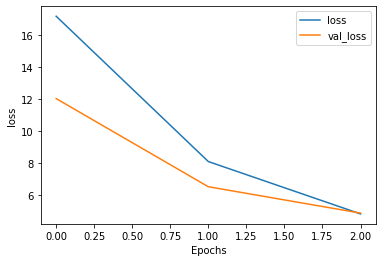

Train on 780 samples
Epoch 1/3
780/780 [==============================] - 3s 4ms/sample - loss: 3.8451
Epoch 2/3
780/780 [==============================] - 1s 820us/sample - loss: 2.5519
Epoch 3/3
780/780 [==============================] - 1s 843us/sample - loss: 1.9219
loss cuts = tf.Tensor(
[1.2465177 1.3190819 1.4340034 1.4386817 1.4599148 1.4321995 1.4639161
 1.4116746 1.4175522 1.4134588 1.340305  1.3935575 1.4400275 1.3615814
 1.4314601 1.4425493 1.420707  1.5365148 1.5356812 1.4777973], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(1.53171, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[0.781385   0.87094736 1.1424075  1.1850704  1.1319175  1.0954143
 1.1765146  1.0898983  1.0556626  1.0324018  0.9304447  0.96350044
 1.0573256  0.91919136 1.0519127  1.1153544  1.076797   1.1052365
 1.1603624  1.1298461 ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(1.2265476, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[0.6706012  0.76092005 1.0859966  1.1650167  1.0533664  1

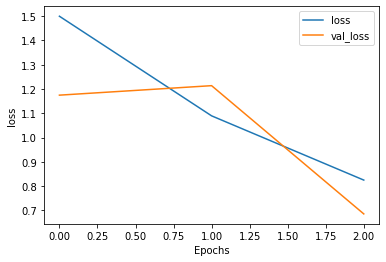

Train on 780 samples
Epoch 1/3
780/780 [==============================] - 1s 840us/sample - loss: 0.7207
Epoch 2/3
780/780 [==============================] - 1s 833us/sample - loss: 0.6181
Epoch 3/3
780/780 [==============================] - 1s 837us/sample - loss: 0.3483
loss cuts = tf.Tensor(
[1.1804681 1.1334403 1.4453723 1.4891831 1.4280643 1.3462106 1.3992827
 1.4561303 1.3067306 1.2834911 1.3615922 1.1924068 1.3075327 1.2786225
 1.337739  1.4485676 1.4148923 1.3470517 1.4397893 1.3469357], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(1.0995587, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.1477935 1.098512  1.417971  1.4761494 1.3703908 1.2816133 1.3378738
 1.3942963 1.2486811 1.2201974 1.2919858 1.1484821 1.2437836 1.2140384
 1.2756286 1.392826  1.3536702 1.3128703 1.416138  1.3202376], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(0.99431866, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.2379283 1.1840391 1.5059398 1.5732405 1.4441124 1.357747  1.4115893


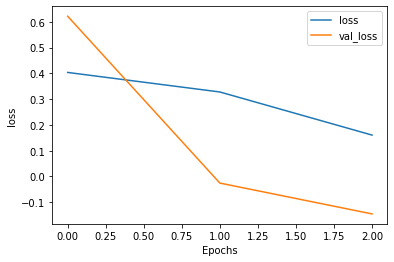

Train on 780 samples
Epoch 1/3
780/780 [==============================] - 1s 858us/sample - loss: 0.0921
Epoch 2/3
780/780 [==============================] - 1s 861us/sample - loss: 0.0032
Epoch 3/3
780/780 [==============================] - 1s 832us/sample - loss: -8.5241e-04
loss cuts = tf.Tensor(
[1.4051219 1.5075351 1.6509906 1.7418023 1.5658084 1.521797  1.5525491
 1.5902385 1.5299811 1.4616144 1.4277384 1.3467834 1.3692132 1.3633958
 1.5079011 1.5892153 1.5883741 1.453648  1.5057293 1.5534737], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(1.0720507, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.3579351 1.4427373 1.5763053 1.6673522 1.4907421 1.4567631 1.4809375
 1.5163777 1.4671807 1.4000497 1.3795699 1.3006213 1.3255386 1.3233776
 1.4474496 1.5199931 1.5265698 1.3973393 1.4343041 1.4878331], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(1.193957, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.2988877 1.3780422 1.5230331 1.6271092 1.4380559 1.4047712 1.42936

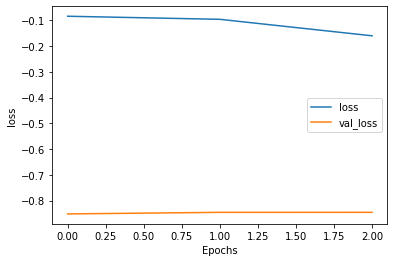

Train on 780 samples
Epoch 1/3
780/780 [==============================] - 1s 836us/sample - loss: -0.2922
Epoch 2/3
780/780 [==============================] - 1s 825us/sample - loss: -0.3335
Epoch 3/3
780/780 [==============================] - 1s 823us/sample - loss: -0.3375
loss cuts = tf.Tensor(
[1.4402215 1.444957  1.59771   1.6573386 1.5405176 1.5634142 1.5301803
 1.5789542 1.48815   1.4344267 1.4508687 1.3798513 1.3497145 1.3151911
 1.4986207 1.558735  1.572143  1.4706664 1.5556375 1.5619476], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(2.3019004, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.4773049 1.485212  1.6215676 1.6826811 1.572023  1.5950233 1.5598373
 1.6099471 1.5180899 1.4695616 1.4848205 1.4148444 1.3831891 1.351431
 1.5324855 1.5882336 1.6100034 1.5017669 1.5864726 1.5971093], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(2.3163471, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.4825156 1.496708  1.6094413 1.6567793 1.5723292 1.592758  1.556026


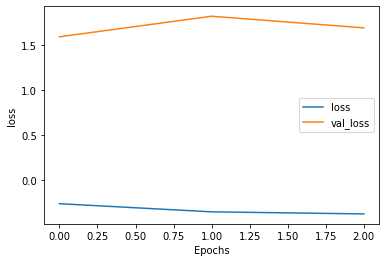

Train on 780 samples
Epoch 1/3
780/780 [==============================] - 1s 848us/sample - loss: -0.2742
Epoch 2/3
780/780 [==============================] - 1s 845us/sample - loss: -0.3973
Epoch 3/3
780/780 [==============================] - 1s 832us/sample - loss: -0.4227
loss cuts = tf.Tensor(
[1.3741331 1.428039  1.5152686 1.4823298 1.3975261 1.4885674 1.4617383
 1.4411309 1.4458408 1.3713409 1.3981379 1.3340808 1.3992201 1.3246361
 1.3871729 1.4032514 1.514899  1.4135251 1.5036507 1.4778032], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(1.3718374, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.3604193 1.4026572 1.4754575 1.4601002 1.390876  1.4534093 1.438013
 1.4242892 1.4204388 1.3630091 1.3832834 1.3390145 1.3858631 1.3268381
 1.377603  1.3923529 1.4656911 1.3960593 1.468065  1.4449248], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(1.3793347, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.3845588 1.431271  1.508433  1.5043694 1.4312018 1.5001605 1.4811774

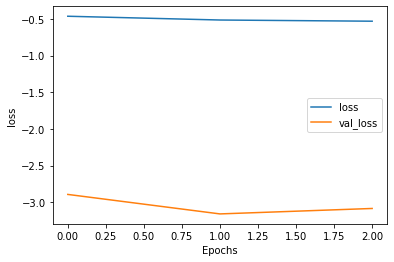

Train on 780 samples
Epoch 1/3
780/780 [==============================] - 1s 842us/sample - loss: -0.4623
Epoch 2/3
780/780 [==============================] - 1s 827us/sample - loss: -0.4556
Epoch 3/3
780/780 [==============================] - 1s 840us/sample - loss: -0.4939
loss cuts = tf.Tensor(
[1.4610802 1.4774432 1.5675201 1.6608473 1.5232693 1.6354737 1.5930476
 1.6238916 1.5521196 1.5165457 1.5165144 1.4109586 1.4799529 1.4584394
 1.482303  1.4935517 1.5343391 1.4983782 1.6101476 1.516112 ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(1.1667483, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.5006477 1.5373336 1.6542894 1.8011923 1.56978   1.7780241 1.6984844
 1.741066  1.6518127 1.5934044 1.5849582 1.4073819 1.5280248 1.5064554
 1.5368286 1.5474881 1.6529379 1.5526965 1.7427121 1.5639856], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(1.1294863, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.4832482 1.5302521 1.6314654 1.8008599 1.5202619 1.7962998 1.674184

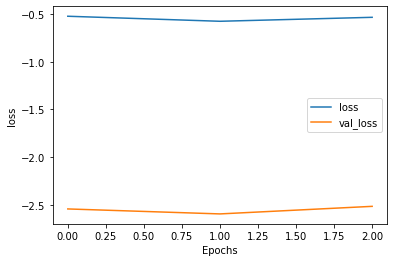

Train on 780 samples
Epoch 1/3
780/780 [==============================] - 1s 836us/sample - loss: -0.5703
Epoch 2/3
780/780 [==============================] - 1s 828us/sample - loss: -0.6223
Epoch 3/3
780/780 [==============================] - 1s 831us/sample - loss: -0.6574
loss cuts = tf.Tensor(
[1.6153808 1.5138181 1.6391296 1.8016973 1.7194091 1.8824168 1.8058307
 1.7636577 1.6043164 1.5799708 1.5724889 1.381637  1.448001  1.4299288
 1.4701105 1.5017833 1.6890448 1.4845768 1.6984516 1.5728296], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(9.211902, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.5772972 1.4885292 1.5916395 1.7527988 1.6609726 1.8182633 1.7378912
 1.6934958 1.5576093 1.5404634 1.5323143 1.3881924 1.4366839 1.4213955
 1.4533956 1.4772444 1.6158743 1.4671838 1.6506016 1.5411372], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(9.4141865, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.5583493 1.477981  1.5613055 1.7109685 1.6317881 1.8091785 1.7200125

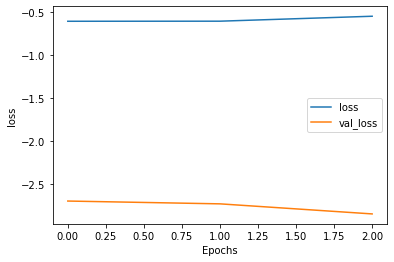

Train on 780 samples
Epoch 1/3
780/780 [==============================] - 1s 841us/sample - loss: -0.6484
Epoch 2/3
780/780 [==============================] - 1s 824us/sample - loss: -0.6790
Epoch 3/3
780/780 [==============================] - 1s 812us/sample - loss: -0.7048
loss cuts = tf.Tensor(
[1.6821519 1.625168  1.6606113 1.6193429 1.6333071 1.7942119 1.7304316
 1.5642836 1.6016952 1.5326797 1.6138506 1.4252409 1.5137206 1.4888672
 1.5002718 1.4885515 1.5849419 1.4911622 1.6630474 1.6139416], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(3.2091968, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.5362164 1.51395   1.5492369 1.5385149 1.5355097 1.5942744 1.5704051
 1.5119148 1.5159763 1.4884796 1.5211778 1.427524  1.4729265 1.4559995
 1.4703056 1.4685311 1.5090431 1.4687139 1.5562191 1.523162 ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(3.2256439, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.5020998 1.4854727 1.530347  1.5184747 1.5138017 1.5808    1.550861

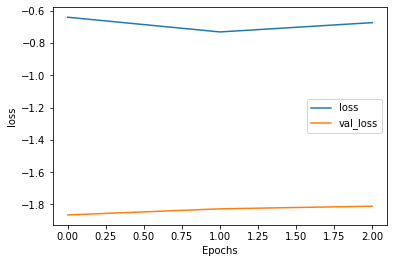

Train on 780 samples
Epoch 1/3
780/780 [==============================] - 1s 824us/sample - loss: -0.7007
Epoch 2/3
780/780 [==============================] - 1s 808us/sample - loss: -0.7578
Epoch 3/3
780/780 [==============================] - 1s 811us/sample - loss: -0.7719
loss cuts = tf.Tensor(
[1.5291166 1.4935389 1.551331  1.5357935 1.5482962 1.6039374 1.5647724
 1.537252  1.5329537 1.4959593 1.5184553 1.4694636 1.4943931 1.4831166
 1.5127108 1.4978359 1.5031614 1.4827373 1.5558791 1.4750514], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(1.6498861, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.5919557 1.5380175 1.6327083 1.6091018 1.6372335 1.7554922 1.6829641
 1.6162393 1.6021218 1.544497  1.5795798 1.5042274 1.5434036 1.5282528
 1.5672128 1.5446515 1.5540066 1.5229695 1.6336362 1.5176079], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(2.283938, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.6893884 1.6193529 1.7419579 1.7112491 1.7503781 1.9101663 1.8225688

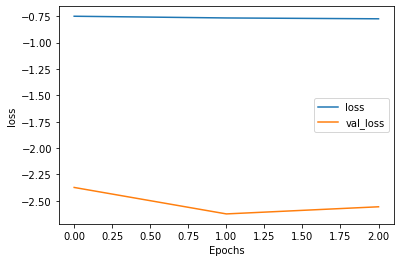

Train on 780 samples
Epoch 1/3
780/780 [==============================] - 1s 835us/sample - loss: -0.7735
Epoch 2/3
780/780 [==============================] - 1s 825us/sample - loss: -0.7123
Epoch 3/3
780/780 [==============================] - 1s 829us/sample - loss: -0.7772
loss cuts = tf.Tensor(
[1.5983777 1.6259643 1.707415  1.8373116 1.8300304 2.2306175 1.872761
 2.1457686 1.8531862 1.7538681 1.8870794 1.5900414 1.5908587 1.5389247
 1.6036563 1.6272448 1.676236  1.5900992 1.6350737 1.6278775], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(2.6296704, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.6149614 1.6418769 1.7146521 1.8161769 1.8095586 2.1313548 1.836195
 2.0652108 1.8291478 1.7512507 1.8628957 1.6123564 1.6115949 1.5699048
 1.62412   1.6427796 1.6822028 1.6096787 1.6461203 1.6429813], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(2.3059342, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.5757548 1.6039293 1.6758524 1.7665445 1.7647386 2.0903454 1.7832043


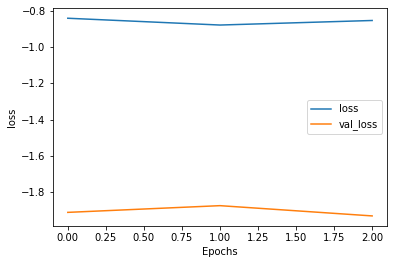

Train on 780 samples
Epoch 1/3
780/780 [==============================] - 1s 852us/sample - loss: -0.7538
Epoch 2/3
780/780 [==============================] - 1s 823us/sample - loss: -0.7780
Epoch 3/3
780/780 [==============================] - 1s 834us/sample - loss: -0.8795
loss cuts = tf.Tensor(
[1.4597812 1.421758  1.5172442 1.5682875 1.5483354 1.5572335 1.5450559
 1.5410063 1.4975246 1.4596407 1.5317765 1.5169675 1.5033163 1.4944172
 1.4932514 1.5046223 1.4832377 1.4666914 1.5288972 1.5039195], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(6.8796678, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.4790645 1.4607823 1.51725   1.5480433 1.5360903 1.5385779 1.5319339
 1.5297879 1.5041851 1.4807047 1.5228713 1.5148693 1.5089633 1.5030485
 1.5054345 1.5133888 1.5009665 1.4924934 1.5297838 1.5135607], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(6.7931023, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.4402051 1.4288877 1.4695257 1.49228   1.4827721 1.4831986 1.479116

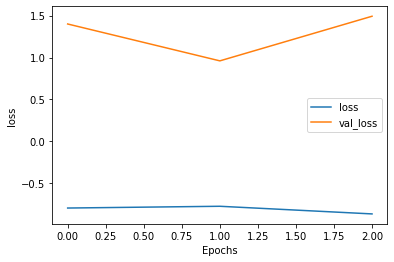

Train on 780 samples
Epoch 1/3
780/780 [==============================] - 1s 857us/sample - loss: -0.8492
Epoch 2/3
780/780 [==============================] - 1s 849us/sample - loss: -0.8587
Epoch 3/3
780/780 [==============================] - 1s 843us/sample - loss: -0.7794
loss cuts = tf.Tensor(
[1.4374695 1.4384413 1.4572217 1.466682  1.4638972 1.4696784 1.467651
 1.4724745 1.4573946 1.4453208 1.4534612 1.4498365 1.4498475 1.4501135
 1.4568324 1.4631953 1.4483093 1.4507327 1.4846008 1.463907 ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(3.4300735, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.4222065 1.4228806 1.4548753 1.4610258 1.4453509 1.457708  1.4515485
 1.4640604 1.4423833 1.4221333 1.4306153 1.4270893 1.4270185 1.4323449
 1.4386971 1.4510038 1.4295774 1.433463  1.5033917 1.454764 ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(3.3108315, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.4083464 1.4101794 1.4378521 1.4413621 1.4268595 1.4393997 1.4320621

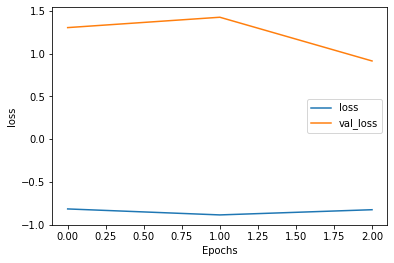

Train on 780 samples
Epoch 1/3
780/780 [==============================] - 1s 845us/sample - loss: -0.8079
Epoch 2/3
780/780 [==============================] - 1s 831us/sample - loss: -0.9096
Epoch 3/3
780/780 [==============================] - 1s 831us/sample - loss: -0.9249
loss cuts = tf.Tensor(
[1.4457046 1.4111798 1.4610218 1.568423  1.4640496 1.5271469 1.5083241
 1.5272634 1.4801853 1.4671388 1.4598107 1.4360303 1.4622823 1.445967
 1.4434856 1.4785422 1.4544116 1.4498768 1.4811645 1.4828968], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(23.41541, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.3740035 1.3382983 1.3804172 1.4380144 1.3899361 1.4209845 1.4194226
 1.4273418 1.4020718 1.3914561 1.3872477 1.3640605 1.3852192 1.3764666
 1.375269  1.3950279 1.3762836 1.3715593 1.3751869 1.4002081], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(24.280638, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.3814468 1.344703  1.3887477 1.4469174 1.398471  1.4290448 1.4277649


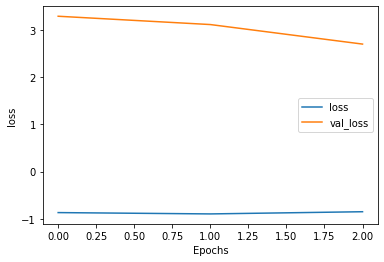

Train on 780 samples
Epoch 1/3
780/780 [==============================] - 1s 842us/sample - loss: -0.7733
Epoch 2/3
780/780 [==============================] - 1s 841us/sample - loss: -0.8189
Epoch 3/3
780/780 [==============================] - 1s 831us/sample - loss: -0.9068
loss cuts = tf.Tensor(
[1.464669  1.4352943 1.4991461 1.4978594 1.4565262 1.4942684 1.4366932
 1.432755  1.3886752 1.4214454 1.4699435 1.4250034 1.3812257 1.3707844
 1.3627281 1.4328699 1.4465045 1.5154421 1.5787579 1.478044 ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(11.205812, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.6078215 1.54493   1.6157696 1.6264817 1.56621   1.605674  1.5412065
 1.5401896 1.4993696 1.5346348 1.589429  1.5575294 1.5062983 1.4955349
 1.4879422 1.586586  1.6039515 1.6764954 1.768802  1.6343317], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(10.32564, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.5337191 1.5030828 1.5600328 1.5627933 1.5236843 1.5611336 1.4798276

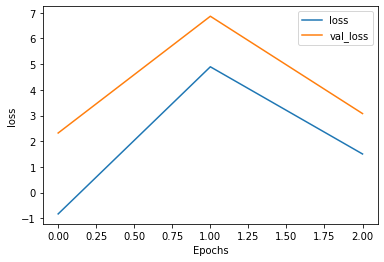

Train on 780 samples
Epoch 1/3
780/780 [==============================] - 1s 848us/sample - loss: -0.0565
Epoch 2/3
780/780 [==============================] - 1s 842us/sample - loss: -0.4233
Epoch 3/3
780/780 [==============================] - 1s 820us/sample - loss: -0.6095
loss cuts = tf.Tensor(
[1.7091453 1.5763478 1.7235937 1.83567   1.656234  1.7094531 1.6905437
 1.6771905 1.7373545 1.7626576 1.8120494 1.612416  1.6265988 1.59692
 1.730639  1.7535934 1.765796  1.9513893 2.3115797 1.987438 ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(2.9004033, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.6948229 1.5529984 1.7027956 1.8275723 1.6275538 1.6740255 1.6605053
 1.6487787 1.7081268 1.7362981 1.7859747 1.5900973 1.6019202 1.5713772
 1.6962692 1.7265923 1.7472922 1.9378068 2.2987342 1.967857 ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(2.8896508, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[1.6326035 1.4736525 1.6015213 1.7074525 1.5355523 1.5661312 1.5533803


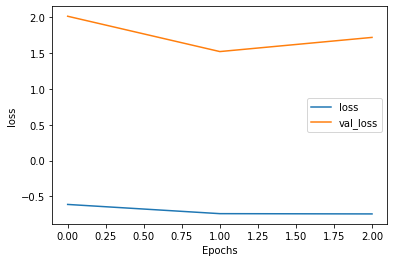

Train on 780 samples
Epoch 1/3
780/780 [==============================] - 1s 842us/sample - loss: -0.6925
Epoch 2/3
780/780 [==============================] - 1s 850us/sample - loss: -0.7317
Epoch 3/3
780/780 [==============================] - 1s 839us/sample - loss: -0.7933
loss cuts = tf.Tensor(
[1.9333432 2.0367408 2.2142317 2.51928   2.3741732 2.3121257 2.1444938
 2.0742812 2.0942032 2.298201  2.0116084 2.1427903 2.0345097 2.0700512
 2.0288053 2.1078622 2.1725886 2.3885918 3.1084876 2.3501825], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(4.0410905, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[2.1077793 2.1974986 2.3729444 2.6495626 2.5339887 2.4688735 2.279308
 2.2124631 2.233883  2.4730556 2.1602297 2.2885075 2.191245  2.2167919
 2.161851  2.241879  2.3151453 2.5269797 3.153735  2.5109699], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(4.3702917, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[2.18693   2.2923095 2.4693599 2.761931  2.6162822 2.5501797 2.3802829

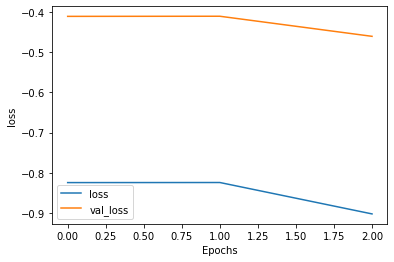

Train on 780 samples
Epoch 1/3
780/780 [==============================] - 1s 820us/sample - loss: -0.8741
Epoch 2/3
780/780 [==============================] - 1s 815us/sample - loss: -0.9548
Epoch 3/3
780/780 [==============================] - 1s 816us/sample - loss: -0.9681
loss cuts = tf.Tensor(
[2.2395852 2.2286923 2.2434642 1.9705031 2.0339959 1.92012   1.8786675
 1.8123677 1.8375167 1.8961253 2.0882726 2.0274262 2.254156  1.8592573
 1.8426753 2.0608737 1.9439918 2.0417068 2.81745   1.9442666], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(8.041918, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[2.193086  2.130476  2.2368605 1.9507033 1.9552735 1.8800932 1.7851317
 1.7222217 1.7460079 1.7958399 1.955848  1.8956102 2.1750877 1.7584424
 1.7532562 1.9731308 1.8618317 1.9885992 2.7363398 1.8412715], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(7.9466906, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[2.4333878 2.196415  2.741849  2.4646816 2.1019819 2.2244902 1.8611794

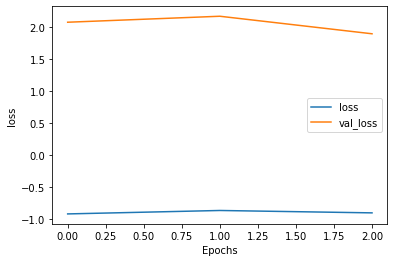

Train on 780 samples
Epoch 1/3
780/780 [==============================] - 1s 842us/sample - loss: -0.8238
Epoch 2/3
780/780 [==============================] - 1s 832us/sample - loss: -0.9181
Epoch 3/3
780/780 [==============================] - 1s 833us/sample - loss: -0.9386
loss cuts = tf.Tensor(
[2.9741237 2.800629  3.4350288 3.3610508 3.3886359 3.3000674 3.4034586
 3.401325  2.8600154 3.2207024 3.4191751 3.3759875 3.0680423 2.873769
 3.2372046 3.4055758 2.9095278 3.2575014 3.0728512 3.2603335], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(3.3200917, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[2.802008  2.6212368 3.564694  3.4904304 3.460597  3.4219108 3.5192652
 3.515049  2.7171729 2.9730556 3.53163   3.4638042 2.921574  2.7557065
 3.1339924 3.472555  2.7666554 3.3681028 3.1780038 3.3209617], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(3.145563, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[2.792686  2.6268373 3.6934924 3.6240017 3.5823753 3.5550807 3.6462095


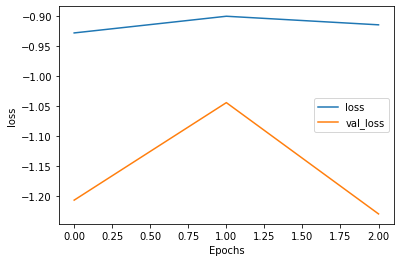

Train on 780 samples
Epoch 1/3
780/780 [==============================] - 1s 839us/sample - loss: -0.9622
Epoch 2/3
780/780 [==============================] - 1s 836us/sample - loss: -0.9959
Epoch 3/3
780/780 [==============================] - 1s 830us/sample - loss: -1.0115
loss cuts = tf.Tensor(
[3.2938068 3.0362942 3.6635883 3.629033  3.5868835 3.5725439 3.5063097
 3.5801327 3.4948676 3.0624394 3.6139865 3.600673  2.981065  3.0925872
 3.0147393 3.0604708 3.1134574 3.2070851 3.4890647 3.4439595], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(2.0736277, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[3.5797112 3.5082777 3.6664681 3.6247966 3.5590184 3.5625236 3.6193442
 3.5824094 3.5517101 3.5896163 3.5868077 3.5830438 3.6572506 3.649397
 3.6539316 3.6492941 3.663324  3.6592102 3.473733  3.5563517], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(2.8635724, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[3.3535614 3.1771789 3.5457144 3.5145726 3.4658375 3.4572814 3.4820912

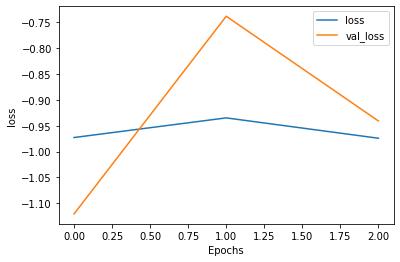

Train on 780 samples
Epoch 1/3
780/780 [==============================] - 1s 853us/sample - loss: -0.9553
Epoch 2/3
780/780 [==============================] - 1s 831us/sample - loss: -0.9790
Epoch 3/3
780/780 [==============================] - 1s 817us/sample - loss: -1.0019
loss cuts = tf.Tensor(
[3.1806471 3.164201  3.5507977 3.5564466 2.8763766 3.527706  3.0763068
 3.3344061 3.066238  2.9969544 3.0304873 3.0109286 2.9854045 3.0386636
 2.977527  2.941311  2.8993835 3.3060443 3.529295  3.5341036], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(1.8008696, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[3.3946354 3.3970199 3.5621152 3.5712888 3.1256857 3.534382  3.401844
 3.4767406 3.3028257 3.0439556 3.2756793 3.0758216 3.068727  3.0993724
 3.036064  3.1202164 3.1587777 3.4641821 3.5321395 3.545217 ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(1.8057215, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[3.2289042 3.3287892 3.5691524 3.5776365 3.0405424 3.541853  3.3841615

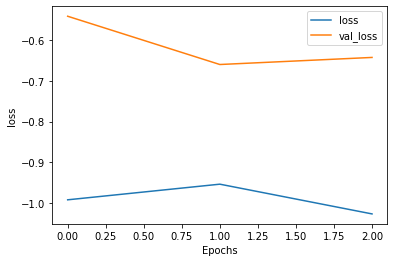

Train on 780 samples
Epoch 1/3
780/780 [==============================] - 1s 851us/sample - loss: -1.0245
Epoch 2/3
780/780 [==============================] - 1s 833us/sample - loss: -1.0245
Epoch 3/3
780/780 [==============================] - 1s 819us/sample - loss: -1.0371
loss cuts = tf.Tensor(
[3.421085  3.417339  3.370157  3.3170776 3.3052878 3.3535693 3.2245495
 3.026336  3.1354358 2.9466996 3.08854   2.9737065 3.2955217 3.2769
 3.2988026 2.9380178 3.3962536 3.3896253 3.3246522 2.8779788], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(2.6934059, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[3.3579164 3.3485568 3.2966828 3.2342124 3.2238212 3.283957  3.1416724
 3.2596087 3.1425638 3.1297626 2.8639274 3.0151606 3.2040687 3.2054005
 3.2245123 2.85682   3.3344955 3.3171883 3.254901  2.7996383], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(2.6390083, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[3.291248  3.278856  3.2198956 3.152077  3.143303  3.2089252 3.0563521
 

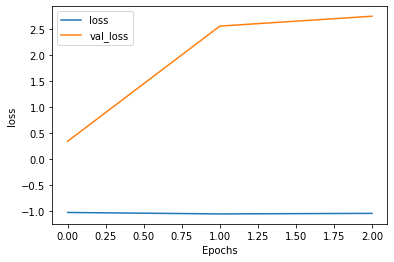

Train on 780 samples
Epoch 1/3
780/780 [==============================] - 1s 864us/sample - loss: -0.9704
Epoch 2/3
780/780 [==============================] - 1s 848us/sample - loss: -0.9541
Epoch 3/3
780/780 [==============================] - 1s 836us/sample - loss: -1.0518
loss cuts = tf.Tensor(
[3.44217   3.4016802 3.3904476 3.3624372 3.3490965 3.3805838 3.257005
 3.326787  3.2805765 3.2937462 3.3145292 3.3781812 3.4071765 3.4111726
 3.43173   3.4064212 3.4633691 3.4459846 3.4206536 3.4320223], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(4.9396753, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[3.2779663 3.2192159 3.2069669 3.178935  3.1620588 3.198116  3.0562768
 3.1389523 3.0886488 3.1023126 3.126494  3.2118156 3.2416563 3.2431197
 3.2696583 3.23867   3.2977662 3.286107  3.2570796 3.2707465], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(5.2779903, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[3.2786555 3.2211568 3.2116177 3.1807494 3.1541395 3.205896  3.046513


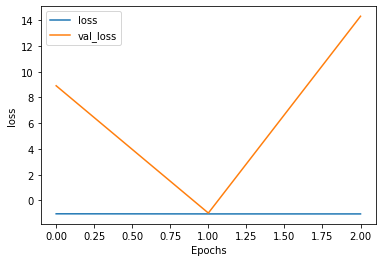

Train on 780 samples
Epoch 1/3
780/780 [==============================] - 1s 859us/sample - loss: 42.5197
Epoch 2/3
780/780 [==============================] - 1s 849us/sample - loss: 26.0489
Epoch 3/3
780/780 [==============================] - 1s 866us/sample - loss: 15.1059
loss cuts = tf.Tensor(
[3.4331343 3.010021  3.4733872 3.2818983 3.347262  3.4664283 3.178638
 3.2887492 3.3518553 3.2988868 3.328277  3.3878095 3.0538058 3.3022208
 3.342141  3.1836176 3.3110268 3.2670827 3.3227255 3.3601952], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(2.5015695, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[3.5354483 2.754778  3.559248  2.785636  3.4791694 3.5912635 3.2674835
 3.3821697 3.4454784 3.3941655 3.303458  3.3696253 2.6870987 3.0711482
 3.1505005 3.1090126 2.9822447 3.3247867 3.1286259 3.468462 ], shape=(20,), dtype=float32)
model2 loss = tf.Tensor(2.5437765, shape=(), dtype=float32)
loss cuts = tf.Tensor(
[3.6058128 3.0397193 3.6554334 3.0900536 3.5470781 3.6416297 3.3592787

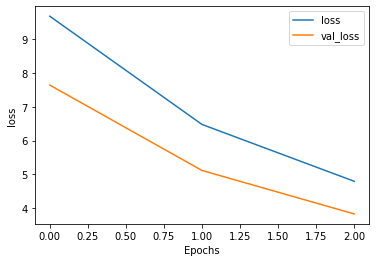

Train on 780 samples
Epoch 1/3
780/780 [==============================] - 1s 837us/sample - loss: 3.8080
Epoch 2/3
780/780 [==============================] - 1s 834us/sample - loss: 3.2688
Epoch 3/3
780/780 [==============================] - 1s 843us/sample - loss: 2.8126
loss cuts = tf.Tensor([3.6522596 3.3164878 3.6437285 3.5310457 3.506725  3.5534992 3.5592017], shape=(7,), dtype=float32)
model2 loss = tf.Tensor(2.3260627, shape=(), dtype=float32)
loss cuts = tf.Tensor([3.5824783 3.516313  3.5771255 3.5191832 3.4947934 3.4613833 3.4906821], shape=(7,), dtype=float32)
model2 loss = tf.Tensor(2.3857439, shape=(), dtype=float32)
loss cuts = tf.Tensor([3.552256  3.489191  3.5474737 3.4885566 3.4595537 3.4205978 3.4490368], shape=(7,), dtype=float32)
model2 loss = tf.Tensor(2.3258636, shape=(), dtype=float32)
loss cuts = tf.Tensor([3.522656  3.291756  3.5082185 3.3821316 3.3599079 3.3895047 3.3944542], shape=(7,), dtype=float32)
model2 loss = tf.Tensor(2.5057323, shape=(), dtype=float32)

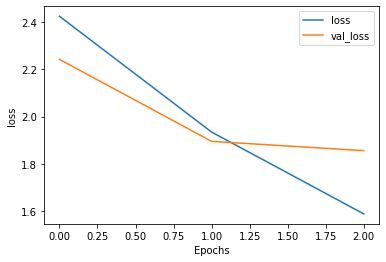

학습 종료.......
2020-06-15:10:57:32


In [16]:
current_train_start = df.loc[prepro.date_to_index(df, train_start), 'date']
current_train_end = df.loc[prepro.date_to_index(df, train_end), 'date']
current_test_start = df.loc[prepro.date_to_index(df, test_start), 'date']
current_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, 'date']


#  각 transfer 구간의 예측값들을 합치기 위하여
test_prediction1 = []
test_prediction2 = []
test_target = []

print("학습 시작")
print(datetime.now().strftime("%Y-%m-%d:%H:%M:%S"))
while True:

    gc.collect()
    

    train_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, 
                                                           current_train_start, current_train_end,
                                                           current_test_start, current_test_end,
                                                           future_day, n_timestep, time_interval)

    # 전체 train, test dataset 생성
    train_x, train_y = prepro.get_LSTM_dataset(train_data, n_timestep, time_interval, input_size, future_day)
    
    # the model1 training dataset
    train_x = train_x[:train_end_back]
    train_y = train_y[:train_end_back]

    # train, validation set 분리하여 train1은 예측모델로 train2는 손절값 학습 모델로 사용
    train1_x, train2_x, train1_y, train2_y = train_test_split(train_x, train_y, test_size=0.4)
    
    # test set 생성
    test_x, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)
    test_y_target = np.expand_dims(test_y[:, :, 3], axis=2)    
    
    # the model1 training
    train1_y_target = np.expand_dims(train1_y[:, :, 3], axis=2)    
    early_stopping1 = tf.keras.callbacks.EarlyStopping(patience=2, verbose=1)
    model1.load_weights(checkpoint_path)
    model1.fit(train1_x, train1_y_target, batch_size=batch_size, epochs=3)#, callbacks=[early_stopping1], validation_data=(test_x, test_y_target))
    model1.save_weights(checkpoint_path)
    
    
    # the model2 test input 생성
    preds = tf.cast(model1(test_x), dtype=tf.float64)
    targets = test_y_target.copy()
    targets[:, -max(1, int(future_day/time_interval)):, :] = 0    
    test_x_m2 = tf.concat([preds, targets], 2)
    
    # the model2 training
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)    
    early_stopping2 = learn.EarlyStopping(patience=2, verbose=1)
    iter = epochs
    basic_epochs = tf.cast(epochs / 5, dtype=tf.int32)
    for iteration in range(iter):
        batch_input, batch_output = learn.next_random_serial_batch(train2_x, train2_y, batch_size)

        gradients2 = gradient2(model1, model2, batch_input, batch_output)
        optimizer.apply_gradients(zip(gradients2, model2.trainable_variables))
        if iteration % 100 == 0:

            # model2의 test output 생성
            loss_cuts = tf.reshape(model2(test_x_m2)[:, -1, 0], [-1])
            print('loss cuts =', loss_cuts)       

            # model2의 test loss
            loss2 = loss_fn_model2(model1, model2, test_x, test_y)
            print('model2 loss =', loss2)  


        if iteration > iter / 2 and early_stopping2.validate(loss2)==True:
            break    

    if iter > basic_epochs: iter -= basic_epochs
    if iter < basic_epochs: iter = basic_epochs
    
    
    # 다시 전체 데이터셋 예측 모델로 학습    
    train_y_target = np.expand_dims(train_y[:, :, 3], axis=2)        
    model1.load_weights(checkpoint_path)
    history = model1.fit(train_x, train_y_target, batch_size=batch_size, epochs=3, callbacks=[early_stopping1], validation_data=(test_x, test_y_target))
    model1.save_weights(checkpoint_path)
        
    print('test dates ' + current_test_start + "~" + current_test_end)

    # prediction1 accuracy
    updown = np.sign(test_y[:, -1, 3]).reshape((-1))
    prediction1 = model1.predict(test_x)[:, -1, 0].reshape(-1)
    temp = tf.math.multiply(updown, prediction1)
    accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
    print('prediction1 accuracy = ', accu)

    # reinforced prediction2
    preds = tf.cast(model1(test_x), dtype=tf.float64)
    test_x_m2 = tf.concat([preds, targets], 2)
    prediction2 = tf.reshape(model2(test_x_m2)[:, -1, 0], [-1])    
    print('prediction2 = ', prediction2)

    # loss graph
    plot_graphs(history, 'loss')

    test_prediction1.append(prediction1)
    test_prediction2.append(prediction2)

    # escape from while
    if current_test_end == test_end:
     break

    #train, start dates shift
    current_train_end = df.loc[prepro.date_to_index(df, current_train_end) + trans_day, 'date']
    current_train_start = df.loc[prepro.date_to_index(df, current_train_end) - 2000, 'date']
    current_test_start = df.loc[prepro.date_to_index(df, current_test_start) + trans_day, 'date']
    if prepro.date_to_index(df, test_end) - prepro.date_to_index(df, current_test_start) < trans_day:
        current_test_end = test_end
    else:
        current_test_end = df.loc[prepro.date_to_index(df, current_test_end) + trans_day, 'date']
print("학습 종료.......")
print(datetime.now().strftime("%Y-%m-%d:%H:%M:%S"))

In [17]:
t1 = np.concatenate(test_prediction1)
t2 = np.concatenate(test_prediction2)

In [18]:
#test_prediction = np.concatenate(test_prediction, axis=0).reshape((-1, n_timestep, 1))
#train_prediction = learn.predict_batch_test(model1, train_x[:batch_size], len(train_x[:batch_size]))

# 원 지수, 날짜는 target conversion이 되기 전 dataframe에서 가져옴 - 종가를 test base price로 하는 경우
test_dates, test_base_prices, train_dates, train_base_prices = prepro.get_test_dates_prices(dataframe, test_start, test_end,
                                                      train_start, train_end, n_timestep, time_interval, future_day, target_column)


# 전체 test_oouput 생성
_, test_data = prepro.get_train_test_data(df, target_column, remove_columns,
                                                   train_start, train_end,
                                                   test_start, test_end,
                                                   future_day, n_timestep, time_interval)
_, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

In [19]:
updown = np.sign(test_y[:, -1, 3]).reshape((-1))
#calculate accuracy
temp = tf.math.multiply(updown, t1.reshape((-1)))
accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
print('accuracy = ', accu)

accuracy =  tf.Tensor(0.9301848049281314, shape=(), dtype=float64)


In [20]:
updown.shape

(487,)

In [21]:
#train_base_prices = train_base_prices[:batch_size]
#train_prediction = train_prediction[:batch_size]
#train_y = train_y[:batch_size]

In [22]:
result = GenerateResult(t1, t2, test_y[:, -1, 3].reshape(-1), test_dates, n_timestep, future_day, train_end_back, trans_day)

In [23]:
test_start_index = prepro.date_to_index(df, test_start)
test_end_index = prepro.date_to_index(df, test_end)
test_open_prices = list(map(float, df.loc[test_start_index - future_day: test_end_index - future_day, '시가']))
test_high_prices = list(map(float, df.loc[test_start_index - future_day: test_end_index - future_day, '고가']))
test_low_prices = list(map(float, df.loc[test_start_index - future_day: test_end_index - future_day, '저가']))

In [24]:
#result.extract_last_output()
result.convert_price(test_base_prices,conversion_type=target_type)
# 손익 계산
profits = np.zeros(len(test_dates))
for i in range(len(test_dates)):
    if result.test_predict_price[i]-test_open_prices[i] > 0:
        profits[i] = result.test_output_price[i] - test_open_prices[i]
    else:
        profits[i] = test_open_prices[i] - result.test_output_price[i]
# 손절 손익 계산
profits2 = np.zeros(len(test_dates))
for i in range(len(test_dates)):
    if t2[i] <= 0: profits2[i] = profits[i]
    else:
        if result.test_predict_price[i] - test_open_prices[i] > 0:
            if test_open_prices[i] - test_low_prices[i] > t2[i]:
                profits2[i] = -t2[i]
            else:
                profits2[i] = profits[i]
        else:
            if test_high_prices[i] - test_open_prices[i] > t2[i]:
                profits2[i] = -t2[i]
            else:
                profits2[i] = profits[i]

info : loss_cut-3_kospi200f_809_0515_06-15:10:57_120_0.474
MSE : 271.2352 , Accuracy : 0.474
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/loss_cut-3_kospi200f_809_0515_06-15:10:57_120_0.474/assets


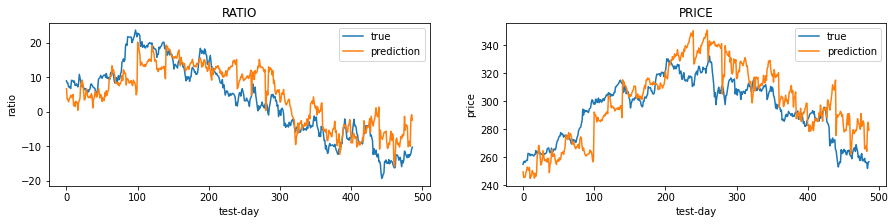

In [25]:
preds = np.array(result.test_predict_price) - np.array(test_open_prices)
trues = np.array(result.test_output_price) - np.array(test_open_prices)
result.evaluation(preds, trues)
result.table(test_open_prices, test_high_prices, test_low_prices, profits, profits2)
result.save_result(model_name,item_name,n_unit,target_type,batch_size,n_timestep,time_interval,epochs,str(alpha),comment)
result.save_visualization()
result.save_model(model2)

In [26]:
"""
current_train_start = df.loc[prepro.date_to_index(df, train_start), 'date']
current_train_end = df.loc[prepro.date_to_index(df, train_end), 'date']
current_test_start = df.loc[prepro.date_to_index(df, test_start), 'date']
current_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, 'date']


#  각 transfer 구간의 예측값들을 합치기 위하여
test_prediction1 = []
test_prediction2 = []
test_target = []

# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)
early_stopping = learn.EarlyStopping(patience=2, verbose=1)


gc.collect()

train_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, 
                                                       current_train_start, current_train_end,
                                                       current_test_start, current_test_end,
                                                       future_day, n_timestep, time_interval)

# input_size, columns reset
input_size = len(df.columns) - len(remove_columns)
input_columns = df.columns.copy()

train_x, train_y = prepro.get_LSTM_dataset(train_data, n_timestep, time_interval, input_size, future_day)
test_x, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

#model.compile(optimizer='adam',
#          loss=loss_fn)
#          #callbacks=[cp-callback]
#          #metrics=['accuracy'])

# the firs training dataset
train_x = train_x[:-future_day]
train_y = train_y[:-future_day]    

#global_step = tf.train.get_or_create_global_step()
global_step = tf.Variable(0, trainable=False)
#lr_decay = tf.train.exponential_decay(learning_rate, global_step,
#                                      train_input.shape[0]/batch_size*5, 0.5, staircase=True)
lr_decay = tf.compat.v1.train.exponential_decay(learning_rate,global_step, int(len(train_y)/batch_size), 0.96, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

updown = np.sign(test_y[:, -1, 0]).reshape((-1))    
epochs = len(train_y)
for iteration in range(399):
    batch_input, batch_output = learn.next_random_interval_batch(train_x, train_y, batch_size, future_day)

    #noise = 2*np.random.randn(batch_size,n_timestep,1)
    #batch_output = batch_output+noise
    #batch_input = encoder(train_input[idx])
    gradients1 = gradient1(model1, model2, batch_input, batch_output)
    optimizer.apply_gradients(zip(gradients1, model1.trainable_variables))
    
    targets = tf.reshape(train_y[:, -1, 0], [-1])
    rates = targets / 100
    preds = tf.reshape(model1(train_x, training=False)[:, -1, 0], [-1])
    
    n = len(targets)    
    returns = [1.0]
    losses = []
    for i in range(n - 1):
       
        # average_return, std of returns, remaining days, preds[0] 
        state = []
        
        random_rates = []
        for k in range(i+1):
            random_rates.append(rates[k])
        # 실재 수익률을 기반으로 random 수익률 생성, 예측에 의한 porfits 생성 
        for k in range(i+1, n):
            random_rates.append(tf.random.normal((), mean=targets[k] / 100, stddev=0.1, dtype=tf.float64))
        profits = tf.convert_to_tensor(random_rates, dtype=tf.float64)*tf.cast(preds, dtype=tf.float64) + 1
        
        # 현재까지의 예측에 의한 수익률 기하평균 구하기
        returns_past = []
        for k in range(i+1):
            returns_past.append(profits[k])
        avg_return = tf.cast(tf.math.reduce_prod(returns_past)**(1/(i+1)), dtype=tf.float64)
        
        state.append(avg_return)
        state.append(tf.math.reduce_std(returns))
        state.append((n - i) / n)
        state.append(preds[i])
        state = np.array(state).reshape((1, 4))
     
        # 목표일까지의 기대 기하 평균 수익률 구하기 
        returns_future = []
        for j in range(i+1, n):
            returns_future.append(profits[j])
        avg_return_future = tf.math.reduce_prod(returns_future)**(1/(n-i-1))

        # 예측 기하 평균 수익률과 기대 기하 평균 수익률의 MSE
        value = tf.cast(model2(state, training=True)[0, 0], dtype=tf.float64)
        losses.append((value - avg_return_future)**2)
        if n == 3: break
    print("losses", losses)
    print("value", value)    
    with tf.GradientTape() as tape:
        gradients2 = tape.gradient(tf.math.reduce_sum(losses), model2.trainable_variables)
    optimizer.apply_gradients(zip(gradients2, model2.trainable_variables))
    

    
    if iteration % 100 == 0:
        #test_MSE = model.evaluate(test_x, test_y)
        prediction = model1.predict(test_x)
        prediction_MSE = sum((updown - np.sign(prediction[:, -1, 0]).reshape(-1))**2)/len(test_y)
        print('prediction_MSE =', prediction_MSE)

    if iteration > epochs / 2 and early_stopping.validate(prediction_MSE)==True:
        break
epochs -= epochs / 5
if epochs <= 0: epochs = 100
"""

'\ncurrent_train_start = df.loc[prepro.date_to_index(df, train_start), \'date\']\ncurrent_train_end = df.loc[prepro.date_to_index(df, train_end), \'date\']\ncurrent_test_start = df.loc[prepro.date_to_index(df, test_start), \'date\']\ncurrent_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, \'date\']\n\n\n#  각 transfer 구간의 예측값들을 합치기 위하여\ntest_prediction1 = []\ntest_prediction2 = []\ntest_target = []\n\n# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)\nearly_stopping = learn.EarlyStopping(patience=2, verbose=1)\n\n\ngc.collect()\n\ntrain_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, \n                                                       current_train_start, current_train_end,\n                                                       current_test_start, current_test_end,\n                                                       future_day, n_timestep, time_interval)\n\n# input_size, columns reset\ninput_size 